In [191]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

X = pd.read_csv(r"../data/df_X.csv", engine="pyarrow")
y= pd.read_csv(r"../data/df_y.csv", engine="pyarrow")

# Decision Tree

## Cross validation para achar o melhor depth

Melhor max_depth: 9
Acurácia média: 0.7634


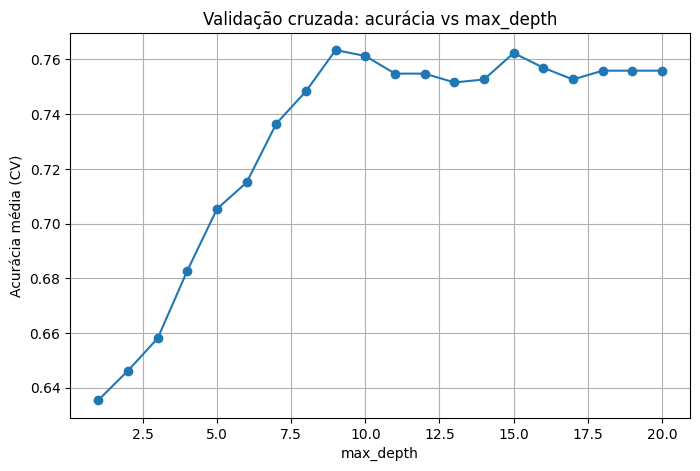

In [192]:
lista_depths = range(1, 21)
mean_scores = []

# Validação cruzada para cada profundidade
for depth in lista_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    mean_scores.append(scores.mean())

# Encontrar a melhor profundidade
melhor_depth = lista_depths[np.argmax(mean_scores)]
melhor_score = max(mean_scores)

print(f"Melhor max_depth: {melhor_depth}")
print(f"Acurácia média: {melhor_score:.4f}")

# Plotar gráfico
plt.figure(figsize=(8, 5))
plt.plot(lista_depths, mean_scores, marker='o')
plt.title('Validação cruzada: acurácia vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Acurácia média (CV)')
plt.grid(True)
plt.show()


## Decision Tree 

In [193]:
#usar o melhor depth nao deu certo, ele esta levando em consideração apenas a acuracia. Não consegui fazer um código que levasse m consideração a média de todos os scores
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = DecisionTreeClassifier(random_state=42, max_depth= melhor_depth)
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)     

print(f"Acurácia      : {acc:.2f}")
print(f"Precisão      : {prec:.2f}")
print(f"Recall        : {rec:.2f}")

Acurácia      : 0.69
Precisão      : 0.70
Recall        : 0.67


                        Feature  Importância (Gini)
4                      Duration            0.213998
0                           Age            0.200605
2              Checking account            0.166871
3                 Credit amount            0.101462
1                           Job            0.054579
17  Purpose_furniture/equipment            0.053207
15                  Purpose_car            0.036828
14             Purpose_business            0.029150
5                    Sex_female            0.026276
10       Saving accounts_little            0.024265
19             Purpose_radio/TV            0.024054
9                  Housing_rent            0.019943
13         Saving accounts_rich            0.012760
7                  Housing_free            0.010038
16            Purpose_education            0.009935
11     Saving accounts_moderate            0.006415
8                   Housing_own            0.003378
18               Purpose_others            0.003150
6           

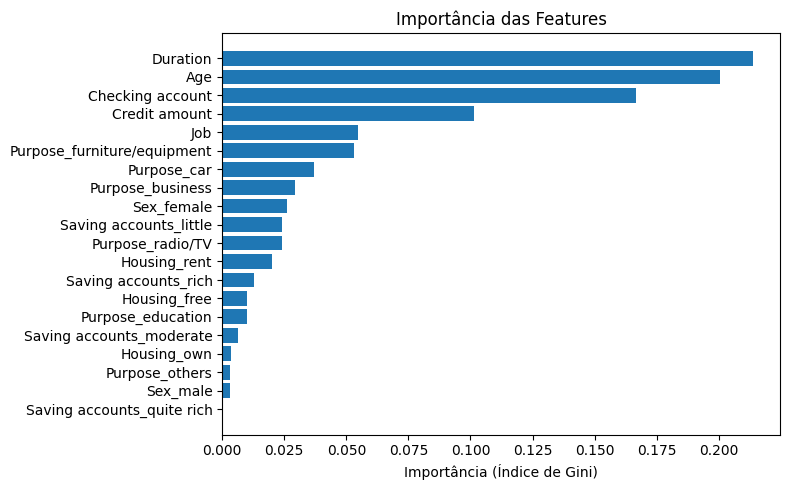

Número de features selecionadas: 10
Features selecionadas: ['Age', 'Job', 'Checking account', 'Credit amount', 'Duration', 'Sex_female', 'Saving accounts_little', 'Purpose_business', 'Purpose_car', 'Purpose_furniture/equipment']


c:\Users\PUC\T1-INF1038\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [194]:
#usando Gini para decidir quais variaveis entram para o modelo final
importancias = model.feature_importances_
feature_names = X.columns

importancia_df = pd.DataFrame({
    'Feature': feature_names,
    'Importância (Gini)': importancias
}).sort_values(by='Importância (Gini)', ascending=False)

print(importancia_df)

plt.figure(figsize=(8, 5))
plt.barh(importancia_df['Feature'], importancia_df['Importância (Gini)'])
plt.xlabel('Importância (Índice de Gini)')
plt.title('Importância das Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

selector = SelectFromModel(model, prefit=True, threshold='median')
X_reduzido = selector.transform(X)

print(f"Número de features selecionadas: {X_reduzido.shape[1]}")
print("Features selecionadas:", X.columns[selector.get_support()].tolist())

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_reduzido, y, test_size=0.2, random_state=42, stratify=y)

model = DecisionTreeClassifier(random_state=42, max_depth=10)
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)     

print(f"Acurácia      : {acc:.2f}")
print(f"Precisão      : {prec:.2f}")
print(f"Recall        : {rec:.2f}")

Acurácia      : 0.72
Precisão      : 0.72
Recall        : 0.73


## KNN

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X_reduzido, y, test_size=0.2, random_state=42, stratify=y)

# Grid de parâmetros
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Modelo base
knn = KNeighborsClassifier()

# GridSearch com validação cruzada (5-fold)
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Melhor estimador
best_knn = grid.best_estimator_

# Predições
probs = best_knn.predict_proba(X_test)[:, 1]
y_pred = best_knn.predict(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print(f"Melhores parâmetros: {grid.best_params_}")
print(f"Acurácia      : {acc:.2f}")
print(f"Precisão      : {prec:.2f}")
print(f"Recall        : {rec:.2f}")


Melhores parâmetros: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Acurácia      : 0.74
Precisão      : 0.71
Recall        : 0.82


c:\Users\PUC\T1-INF1038\venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## Naive Bayes

In [197]:
# Divisão dos dados (mesma lógica dos modelos anteriores)
X_train, X_test, y_train, y_test = train_test_split(
    X_reduzido, y, test_size=0.2, random_state=42, stratify=y
)

# Treinamento do modelo
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predição e avaliação
probs = nb_model.predict_proba(X_test)[:, 1]
y_pred = nb_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print(f"Acurácia      : {acc:.2f}")
print(f"Precisão      : {prec:.2f}")
print(f"Recall        : {rec:.2f}")


Acurácia      : 0.66
Precisão      : 0.65
Recall        : 0.69


c:\Users\PUC\T1-INF1038\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## MLP

In [198]:
# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X_reduzido, y, test_size=0.2, random_state=42, stratify=y
)

# Grid de hiperparâmetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  # regularização L2
    'learning_rate_init': [0.001, 0.01]
}

# Inicialização do modelo
mlp = MLPClassifier(max_iter=1000, random_state=42)

# Validação cruzada com grid search
grid = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Melhor modelo
best_mlp = grid.best_estimator_

# Avaliação
probs = best_mlp.predict_proba(X_test)[:, 1]
y_pred = best_mlp.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print("Melhores parâmetros:", grid.best_params_)
print(f"Acurácia      : {acc:.2f}")
print(f"Precisão      : {prec:.2f}")
print(f"Recall        : {rec:.2f}")


c:\Users\PUC\T1-INF1038\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Melhores parâmetros: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01}
Acurácia      : 0.79
Precisão      : 0.78
Recall        : 0.81


## Curva precision recall

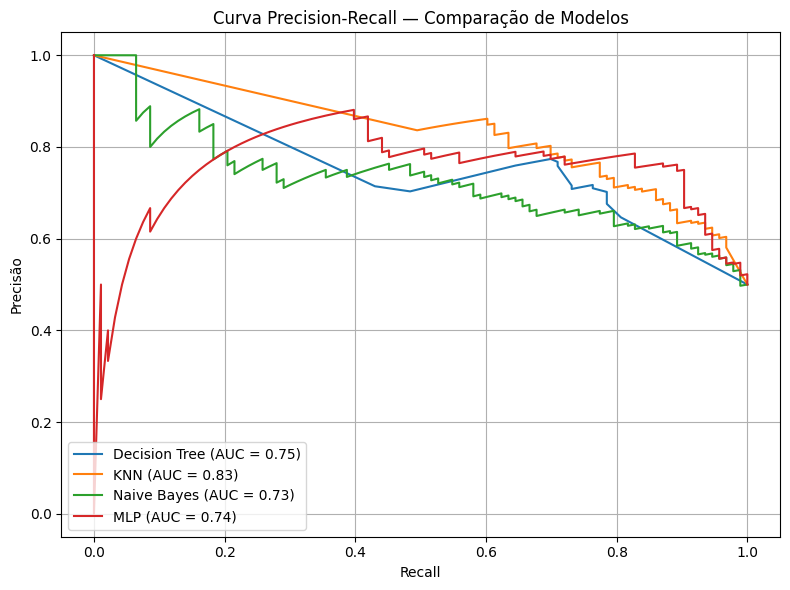

In [199]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Dicionário com os modelos treinados
modelos = {
    "Decision Tree": model,  # ex: DecisionTreeClassifier(...)
    "KNN": best_knn,                      # ex: melhor estimador do GridSearch
    "Naive Bayes": nb_model,              # ex: GaussianNB()
    "MLP": best_mlp                       # ex: melhor estimador do GridSearch
}

plt.figure(figsize=(8, 6))

for nome, modelo in modelos.items():
    # Obter probabilidades da classe positiva
    probs = modelo.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{nome} (AUC = {pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall — Comparação de Modelos")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()
